# Correlate GC-MS and Sensory Data

In [37]:
import pandas as pd
import numpy as np

# Statistics
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import markers

%matplotlib inline

In [146]:
# my palette!
palette_GB = sns.diverging_palette(124, 220, as_cmap=True)

## Load data

In [59]:
Sensory_data = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensory/Sensory_data_median_renamed.csv')
Sensory_data.drop(columns='Unnamed: 0', inplace=True)

# edit the index
Sensory_data['Plot'] = Sensory_data['Sample'].str.extract(r'2022_Plot(\d+)').astype(int)
# Set the new column as the index
Sensory_data.set_index('Plot', inplace=True)
# Drop the original 'Sample' column 
Sensory_data.drop(columns=['Sample'], inplace=True)

Sensory_data

,Olfactory_intensity,Citrus,Exotic_fruit,White_fruit,Floral,Green_notes,Honey,Milk,Mineral,Reduction,...,Olfactory_complexity,CO2,Acidity,Bitterness,Sweetness,Volume_in_the_mouth,Balance,Alcohol,Freshness_on_the_palate,Aromatic_length
Plot,,,,,,,,,,,,,,,,,,,,,
4,4.960,0.6150,2.265,3.600,1.5650,0.1250,0.690,0.095,0.140,0.3650,...,3.130,0.145,4.475,3.425,1.050,1.865,2.800,1.770,3.165,4.655
5,5.160,0.2300,0.405,1.665,0.1850,0.0500,0.140,0.730,0.940,0.1300,...,3.315,0.130,4.775,3.020,3.830,3.050,1.340,2.200,2.700,5.060
9,4.580,0.0405,2.185,1.740,0.0950,0.1200,2.055,0.965,1.295,0.1300,...,3.395,0.115,4.680,2.565,2.135,1.280,2.735,0.925,3.535,4.670
12,4.100,0.1050,0.520,2.545,0.1500,0.0800,1.175,1.920,0.995,0.0855,...,3.315,0.105,5.380,2.725,1.560,2.140,2.640,1.380,3.395,4.765
13,4.520,0.0105,0.445,2.455,0.0255,0.0505,0.545,1.980,2.915,0.7350,...,2.940,0.145,4.085,2.690,1.430,0.680,1.340,2.010,2.470,2.790
14,5.480,0.1200,1.995,3.265,2.0400,0.4100,1.880,0.265,0.235,0.0450,...,4.795,0.435,4.900,2.465,2.280,3.080,2.520,1.820,3.255,4.555
15,4.510,0.0450,0.190,3.890,1.5400,0.1000,1.085,3.205,0.305,0.1500,...,4.030,0.165,5.225,1.650,0.525,1.945,1.720,1.110,4.200,4.580
17,4.925,0.1700,0.175,2.505,0.1850,0.1850,0.070,2.055,0.320,0.4350,...,3.240,0.790,5.245,2.050,2.775,3.425,2.220,2.095,2.515,5.155
19,4.465,0.1100,0.055,1.945,0.1800,0.3700,1.500,0.165,0.810,0.0900,...,2.955,0.060,4.340,1.995,0.880,1.890,2.300,1.320,3.355,3.635


The GC MS data is already normalizesd, but Sensory not. 

Normalizing BOTH has also been done here: Robinson, A. L., Adams, D. O., Boss, P. K., Heymann, H., Solomon, P. S., & Trengove, R. D. (2011). The relationship between sensory attributes and wine composition for Australian Cabernet Sauvignon wines. Australian Journal of Grape and Wine Research, 17(3), 327-340.

> Tried analysis with both and it doesn't change the result 

In [62]:
### TSN normalization
sum_per_profile = Sensory_data.sum(axis=0)
# Apply Total Sum Normalization by dividing each value by the sum of its corresponding column
Sensory_data_normalized = Sensory_data.div(sum_per_profile, axis=1)

Load GC-MS data

In [63]:
GC_data = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/Metabolomics/GC-MS/GC-2021-forCorrelation.csv')

GC_data.drop(columns='Unnamed: 0', inplace=True)
# drop cols with NaN
GC_data_cleaned = GC_data.dropna(axis=1)

# edit the index
GC_data_cleaned['Plot'] = GC_data_cleaned['Name'].str.extract(r'2021_Plot(\d+)').astype(int)
# Set the new column as the index
GC_data_cleaned.set_index('Plot', inplace=True)
# Drop the original 'Sample' column 
GC_data_cleaned.drop(columns=['Name'], inplace=True)


## for some reason 2 samples are missing: Plot 11 and 18 
# remove for now?
index_drop = [11, 18]
GC_data_cleaned = GC_data_cleaned.drop(index=index_drop)

GC_data_cleaned

,Nonanoic acid,"(5Z)-Octa-1,5-dien-3-ol",(S)-(+)-6-Methyl-1-octanol,"1,2-Benzenedicarboxylic acid, bis(2-methylpropyl) ester","1,3-Propanediol, diacetate",1-Butanol,"1-Butanol, 2-methyl-","1-Butanol, 3,3-dimethyl-","1-Butanol, 3-methyl-","1-Butanol, 3-methyl-, acetate",...,Phenethyl alcohol,"Propanoic acid, 2-hydroxy-, ethyl ester, (S)-","Propanoic acid, 2-methyl-",Tetradecane,"Undecanoic acid, ethyl ester",VARAMOL 106 YLBICYCLO[2HYLENE]R]ETHYLPHENYL ESTER]],trans-Geranylacetone,trans-Nerolidol,ß-Citronellol,ß-Damascenone
Plot,,,,,,,,,,,,,,,,,,,,,
12,0.034076,0.000000,0.0,0.0,0.0,0.0,0.025577,0.0,0.034285,0.007783,...,0.146132,0.014056,0.000000,0.001800,0.000351,0.0,0.0,0.000000,0.000000,0.0
13,0.003409,0.000000,0.0,0.0,0.0,0.0,0.045237,0.0,0.048466,0.000000,...,0.143181,0.011981,0.019164,0.004021,0.000256,0.0,0.0,0.000000,0.000714,0.0
14,0.116630,0.002705,0.0,0.0,0.0,0.0,0.030648,0.0,0.045440,0.011036,...,0.106478,0.013808,0.000000,0.001486,0.000000,0.0,0.0,0.001206,0.000000,0.0
15,0.078968,0.002638,0.0,0.0,0.0,0.0,0.034027,0.0,0.025174,0.008808,...,0.135449,0.012523,0.000000,0.001760,0.000000,0.0,0.0,0.000000,0.000000,0.0
17,0.057038,0.002611,0.0,0.0,0.0,0.0,0.028468,0.0,0.069926,0.010616,...,0.122985,0.013668,0.002177,0.002459,0.000000,0.0,0.0,0.000000,0.000000,0.0
19,0.048042,0.000000,0.0,0.0,0.0,0.0,0.026373,0.0,0.052159,0.009772,...,0.138099,0.026112,0.006993,0.003695,0.000000,0.0,0.0,0.000000,0.000000,0.0
20,0.084714,0.000000,0.0,0.0,0.0,0.0,0.020550,0.0,0.056528,0.008421,...,0.210333,0.015053,0.005426,0.005252,0.000285,0.0,0.0,0.000000,0.000617,0.0
4,0.013101,0.000444,0.0,0.0,0.0,0.0,0.034390,0.0,0.066461,0.010587,...,0.161416,0.016864,0.000000,0.002965,0.000418,0.0,0.0,0.000000,0.000000,0.0
5,0.003787,0.000000,0.0,0.0,0.0,0.0,0.034873,0.0,0.066987,0.007182,...,0.177182,0.018668,0.000000,0.002121,0.000372,0.0,0.0,0.000000,0.000510,0.0


# Canonical Correlation Analysis (CCA)
--> not sure if this is proper? Do not see this done in literature! 

In [ ]:
# Initialize CCA
cca = CCA(n_components=2) 
# Fit the data to the CCA model
cca.fit(Sensory_data, GC_data_cleaned)
# Transform the data: dimensionality reduction 
Sensory_c, GC_c = cca.transform(Sensory_data, GC_data_cleaned)

#### The CCA score it 0.58 indicating a strong relationship 

In [ ]:
# Score the CCA model: score shows how well the CCA model fits the provided data.
# 0 means no relationship and 1 means a perfect relationship --> 0.58 is pretty good! 
score = cca.score(Sensory_data, GC_data_cleaned)
# Print the score
print('CCA score: ', score)

#### CCA variables correlate highly

In [ ]:
print('Correlation of 1. components \n ', np.corrcoef(Sensory_c[:, 0], GC_c[:, 0]))
print('Correlation of 2. components \n ', np.corrcoef(Sensory_c[:, 1], GC_c[:, 1]))

In [ ]:
# Plot the first pair of canonical variables
plt.scatter(Sensory_c[:, 0], GC_c[:, 0])
plt.xlabel('Sensory_c1')
plt.ylabel('GC_c1')
plt.title('First pair of canonical variables')
plt.show()
 
# Plot the second pair of canonical variables
plt.scatter(Sensory_c[:, 1], GC_c[:, 1])
plt.xlabel('Sensory_c2')
plt.ylabel('GC_c2')
plt.title('Second pair of canonical variables')
plt.show()

#### Correlation Matrix of Cannonical Variables 

In [ ]:
# Calculate the correlation matrix between canonical variables
correlation_matrix = np.corrcoef(Sensory_c.T, GC_c.T)
 
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', xticklabels=[
            'Sensory_c1', 'GC-MS_c2'], yticklabels=['Sensory_c1', 'GC-MS_c2'])
plt.title('Canonical Variables Correlation Matrix')
plt.show()

In [ ]:
# Initialize CCA
#cca = CCA(n_components=2) 
# Fit the data to the CCA model
#cca.fit(Sensory_data, GC_data_cleaned)
# Transform the data: dimensionality reduction 
#Sensory_c, GC_c = cca.transform(Sensory_data, GC_data_cleaned)



#  sample_ids is a Series containing the Sample IDs corresponding to the rows of cca_df1 and cca_df2
sample_ids = pd.Series(Sensory_data.index)

# Combine the Sample IDs with the transformed DataFrames
cca_combined_df1 = pd.DataFrame(Sensory_c, columns=['CCA_Component_1', 'CCA_Component_2'])
cca_combined_df1['Sample_ID'] = sample_ids
cca_combined_df1['CCA_Dataset'] = 'CCA Dataset 1'

cca_combined_df2 = pd.DataFrame(GC_c, columns=['CCA_Component_1', 'CCA_Component_2'])
cca_combined_df2['Sample_ID'] = sample_ids
cca_combined_df2['CCA_Dataset'] = 'CCA Dataset 2'

cca_combined = pd.concat([cca_combined_df1, cca_combined_df2])

# Create the scatter plot
sns.scatterplot(x='CCA_Component_1', y='CCA_Component_2', 
                data=cca_combined, hue='Sample_ID',
                style='CCA_Dataset', markers=['o', 's'], palette='tab20b')

plt.xlabel('Canonical Component 1')
plt.ylabel('Canonical Component 2')
# plt.title('CCA Scatter Plot')
plt.legend(title='Sample ID')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
# Initialize CCA
cca = CCA(n_components=2)

# Fit the data to the CCA model
cca.fit(Sensory_data, GC_data_cleaned)

# Transform the data: dimensionality reduction
Sensory_c, GC_c = cca.transform(Sensory_data, GC_data_cleaned)

# Get the loadings
Sensory_loadings = cca.x_loadings_
GC_loadings = cca.y_loadings_

# Get the top 5 loadings for Sensory and GC datasets
top_Sensory_loadings_idx = np.argsort(np.abs(Sensory_loadings), axis=0)[-5:]
top_GC_loadings_idx = np.argsort(np.abs(GC_loadings), axis=0)[-5:]

# sample_ids is a Series containing the Sample IDs corresponding to the rows of cca_df1 and cca_df2
sample_ids = pd.Series(Sensory_data.index)

# Combine the Sample IDs with the transformed DataFrames
cca_combined_df1 = pd.DataFrame(Sensory_c, columns=['CCA_Component_1', 'CCA_Component_2'])
cca_combined_df1['Sample_ID'] = sample_ids
cca_combined_df1['CCA_Dataset'] = 'CCA Dataset 1'

cca_combined_df2 = pd.DataFrame(GC_c, columns=['CCA_Component_1', 'CCA_Component_2'])
cca_combined_df2['Sample_ID'] = sample_ids
cca_combined_df2['CCA_Dataset'] = 'CCA Dataset 2'

cca_combined = pd.concat([cca_combined_df1, cca_combined_df2])


In [ ]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='CCA_Component_1', y='CCA_Component_2', data=cca_combined, hue='Sample_ID', style='CCA_Dataset', markers=['o', 's'])

# Plot the top 5 loadings for Sensory dataset
for i in top_Sensory_loadings_idx:
    column_name = Sensory_data.columns[i[0]]
    plt.text(Sensory_loadings[i[0], 0] * 1.1, Sensory_loadings[i[0], 1] * 3, column_name, color='g')
    plt.arrow(0, 0, Sensory_loadings[i[0], 0], Sensory_loadings[i[0], 1], color='g', alpha=0.5)

# Plot the top 5 loadings for GC dataset
for i in top_GC_loadings_idx:
    column_name = GC_data_cleaned.columns[i[0]]
    plt.text(GC_loadings[i[0], 0] * 1.1, GC_loadings[i[0], 1] * 6, column_name, color='b')
    plt.arrow(0, 0, GC_loadings[i[0], 0], GC_loadings[i[0], 1], color='b', alpha=0.5)

plt.xlabel('Canonical Component 1')
plt.ylabel('Canonical Component 2')
plt.legend(title='Sample ID')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


# PLSR analysis 
according to Seisone et al (2016, https://doi.org/10.1016/j.foodchem.2016.04.134) the most common technique to correlate GC-MS and Sensory Data.

Estimated number of components in the Sensory (Y) PCA is 17 (> 21 original variables, see Sensory_Analysis.ipynb) ...  it means the Y-variables are correlated and a single PLS model for all Y-variables is warranted. 

### Determining Number of components 
#### Plot the percent of variance explained in the response variable as a function of the number of components
Ref: https://de.mathworks.com/help/stats/partial-least-squares-regression-and-principal-components-regression.html
Ten components may be more than will be needed to adequately fit the data, but diagnostics from this fit can be used to make a choice of a simpler model with fewer components. For example, one quick way to choose the number of components is to plot the percent of variance explained in the response variable as a function of the number of components.

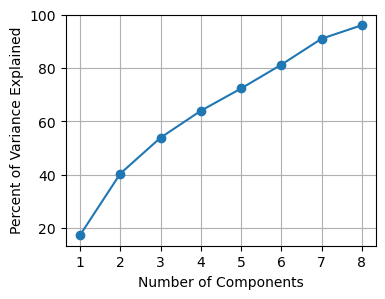

In [74]:
# Convert dataframes to numpy arrays
X = GC_data_cleaned.values
Y = Sensory_data_normalized.values

# Standardize X and Y
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Initialize lists to store explained variance
explained_variances = []

# Define the maximum number of components to try
max_components = min(X_scaled.shape[1], Y_scaled.shape[1])  # Choose the minimum of the two sets of features

# Loop over different numbers of components, limited to the first 8
for n_components in range(1, min(max_components, 8) + 1):
    # Perform PLSR
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_scaled, Y_scaled)
    
    # Calculate the total variance of Y
    total_variance_y = np.var(Y_scaled, axis=0).sum()
    
    # Calculate the residual variance of Y after PLSR
    Y_pred = pls.predict(X_scaled)
    residual_variance_y = np.var(Y_scaled - Y_pred, axis=0).sum()
    
    # Calculate the percent of variance explained
    explained_variance = (total_variance_y - residual_variance_y) / total_variance_y * 100
    explained_variances.append(explained_variance)

# Plot the percent of variance explained for the first 8 components
plt.figure(figsize=(4,3))
plt.plot(range(1, min(max_components, 8) + 1), explained_variances, marker='o')
#plt.title('Percent of Variance Explained vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Percent of Variance Explained')
plt.xticks(range(1, min(max_components, 8) + 1))
plt.grid(True)
plt.show()


#### Leave-one-out cross validatiaon to determine number of components included in PLSR analysis

It's often useful to choose the number of components to minimize the expected error when predicting the response from future observations on the predictor variables. Simply using a large number of components will do a good job in fitting the current observed data, but is a strategy that leads to overfitting. Fitting the current data too well results in a model that does not generalize well to other data, and gives an overly-optimistic estimate of the expected error.

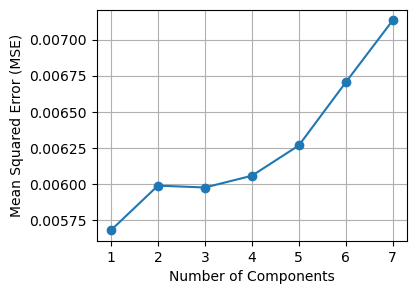

In [71]:
# Define the range of components
n_components_range = range(1, 8)

# Perform leave-one-out cross-validation
loo = LeaveOneOut()
mse_scores = []

for n_components in n_components_range:
    mse_scores_n_components = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # Perform PLSR with the current number of components
        pls = PLSRegression(n_components=n_components)
        pls.fit(X_train, Y_train)
        
        # Predict on the test set
        Y_pred = pls.predict(X_test)
        
        # Calculate MSE
        mse = mean_squared_error(Y_test, Y_pred)
        mse_scores_n_components.append(mse)
    
    # Calculate the mean MSE for the current number of components
    mean_mse_n_components = np.mean(mse_scores_n_components)
    mse_scores.append(mean_mse_n_components)

# Plot the MSE scores
plt.figure(figsize=(4,3))
plt.plot(n_components_range, mse_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (MSE)')
# plt.title('MSE vs. Number of Components in PLSR')
plt.grid(True)
plt.show()


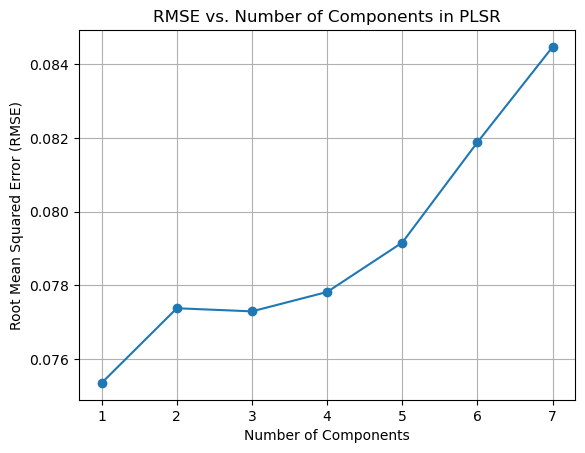

In [75]:
# Define the range of components
n_components_range = range(1, 8)

# Perform leave-one-out cross-validation
loo = LeaveOneOut()
mse_scores = []

for n_components in n_components_range:
    mse_scores_n_components = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # Perform PLSR with the current number of components
        pls = PLSRegression(n_components=n_components)
        pls.fit(X_train, Y_train)
        
        # Predict on the test set
        Y_pred = pls.predict(X_test)
        
        # Calculate MSE
        mse = mean_squared_error(Y_test, Y_pred)
        mse_scores_n_components.append(mse)
    
    # Calculate the mean MSE for the current number of components
    mean_mse_n_components = np.mean(mse_scores_n_components)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_mse_n_components)
    mse_scores.append(rmse)

# Plot the RMSE scores
plt.plot(n_components_range, mse_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE vs. Number of Components in PLSR')
plt.grid(True)
plt.show()

### PLSR

How it works: construct new predictor variables, known as components, as linear combinations of the original predictor variables and PLSR does take the response variable into account, and therefore often leads to models that are able to fit the response variable with fewer components. --> applicable when there are many predictor variables (features) that are highly correlated and possibly noisy! 

0. Determine number of components: how many components explain which variance? What is the MSE with Cross-validation? 
--> choose the number of components to minimize the expected error when predicting the response from future observations on the predictor variables. Fitting the current data too well results in a model that does not generalize well to other data (over-fitting), and gives an overly-optimistic estimate of the expected error. Cross-validation is a more statistically sound method for choosing the number of components in either PLSR or PCR. It avoids overfitting data by not reusing the same data to both fit a model and to estimate prediction error. 

1. first standardize the data, as recommended by good practice. 



> **References**:
> * https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py 
>
> Matlab (but good explanations)
> * https://www.mathworks.com/help/stats/partial-least-squares.html 
> * https://www.mathworks.com/help/stats/partial-least-squares-regression-and-principal-components-regression.html 

In [125]:
# Convert dataframes to numpy arrays
X = GC_data_cleaned.values
Y = Sensory_data_normalized.values

# Standardize X and Y
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

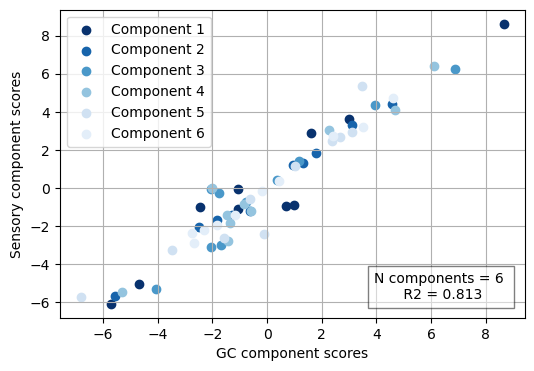

In [126]:
# Perform PLSR with 8 components
pls = PLSRegression(n_components=6)
pls.fit(X_scaled, Y_scaled)

# Get the R2 score
r2_score = pls.score(X_scaled, Y_scaled)

# Get the transformed scores
X_scores, Y_scores = pls.transform(X_scaled, Y_scaled)

cmap = matplotlib.cm.get_cmap('Blues')

# Create a scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(X_scores[:, 0], Y_scores[:, 0], color=cmap(0.99), label='Component 1')
plt.scatter(X_scores[:, 1], Y_scores[:, 1], color=cmap(0.8), label='Component 2')
plt.scatter(X_scores[:, 2], Y_scores[:, 2], color=cmap(0.6), label='Component 3')
plt.scatter(X_scores[:, 3], Y_scores[:, 3], color=cmap(0.4), label='Component 4')
plt.scatter(X_scores[:, 4], Y_scores[:, 4], color=cmap(0.2), label='Component 5')
plt.scatter(X_scores[:, 5], Y_scores[:, 5], color=cmap(0.1), label='Component 6')
plt.xlabel('GC component scores')
plt.ylabel('Sensory component scores')
#plt.title(f'N components = 6, R2 = {r2_score:.3f}')  # Include R2 in the title
plt.text(0.82, 0.1, f'N components = 6 \n R2 = {r2_score:.3f}', ha='center', va='center', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
plt.grid(True)
plt.show()

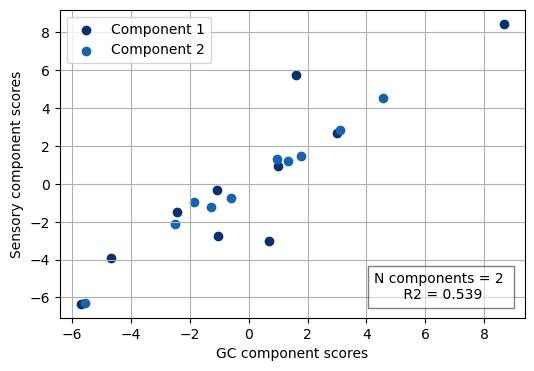

In [127]:
# Perform PLSR with 3 components
pls = PLSRegression(n_components=3)
pls.fit(X_scaled, Y_scaled)

r2_score = pls.score(X_scaled, Y_scaled)

# Get the transformed scores
X_scores, Y_scores = pls.transform(X_scaled, Y_scaled)

cmap = matplotlib.cm.get_cmap('Blues')

# Create a scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(X_scores[:, 0], Y_scores[:, 0], color=cmap(0.99), label='Component 1')
plt.scatter(X_scores[:, 1], Y_scores[:, 1], color=cmap(0.8), label='Component 2')
plt.xlabel('GC component scores')
plt.ylabel('Sensory component scores')
#plt.title(f'N components = 2, R2 = {r2_score:.3f}')  # Include R2 in the title
plt.text(0.82, 0.1, f'N components = 2 \n R2 = {r2_score:.3f}', ha='center', va='center', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
plt.grid(True)
plt.show()

### Get the loadings

Ref? 

https://learnche.org/pid/latent-variable-modelling/projection-to-latent-structures/how-the-pls-model-is-calculated

In [128]:
# Perform PLSR with 3
pls = PLSRegression(n_components=3)
pls.fit(X_scaled, Y_scaled)

# Get the loadings
X_loadings = pls.x_loadings_
Y_loadings = pls.y_loadings_

In [129]:
# get GC components names 
GC_loadings = GC_data_cleaned.columns.to_list()
# get loadings 
df_GC_loadings = pd.DataFrame(GC_loadings, columns=['ID'])
loadings_df = pd.DataFrame(X_loadings, columns=['L1', 'L2', 'L3']) # note, if n_components changes this has to be adapted!
# merge them - the order should be the same (yes?)
df_GC_loadings_all = df_GC_loadings.join(loadings_df)
df_GC_loadings_all = df_GC_loadings_all.set_index(['ID'])
df_GC_loadings_all

# Calculate the absolute maximal value for each row
df_GC_loadings_all['max_abs'] = df_GC_loadings_all.abs().max(axis=1)
# Sort the DataFrame by the absolute maximal value
df_GC_loadings_sorted = df_GC_loadings_all.sort_values(by='max_abs', ascending=False)
# Drop the temporary 'max_abs' column if not needed
df_GC_loadings_sorted = df_GC_loadings_sorted.drop(columns='max_abs')

In [130]:
df_GC_loadings_all_sorted1

,L1,L2,L3,max_abs
ID,,,,
"1-Butanol, 3-methyl-, acetate",-0.186748,0.020081,-0.028520,0.186748
"(5Z)-Octa-1,5-dien-3-ol",-0.183197,-0.139803,0.051550,0.183197
4-pentylbutan-4-olide,-0.182398,0.096118,0.063968,0.182398
4-isopropenyl-5-methyl-4-hexen-1-al,-0.164770,0.054101,0.079022,0.164770
1-Tridecanol,-0.160266,-0.129003,0.136966,0.160266
...,...,...,...,...
2-Heptanol,0.187758,0.040605,-0.100331,0.187758
Ethyl heptanoate,0.191208,0.101182,-0.005604,0.191208
Isobutyl octanoate,0.191403,-0.006457,0.160991,0.191403


note this has been changed to make the biplot!

In [131]:
# top for component 1 
df_GC_loadings_all_sorted1 = df_GC_loadings_all.sort_values(by=['L1'])
# only get first col and the head and tail 
head_L1 = pd.DataFrame(df_GC_loadings_all_sorted1.head(5).iloc[:, 0])
tail_L1 = pd.DataFrame(df_GC_loadings_all_sorted1.tail(5).iloc[:, 0])
GC_L1 = pd.concat([head_L1, tail_L1], axis=0)

# top for component 2 
df_GC_loadings_all_sorted2 = df_GC_loadings_all.sort_values(by=['L2'])
# only get first col and the head and tail 
head_L2 = pd.DataFrame(df_GC_loadings_all_sorted2.head(5).iloc[:, 1])
tail_L2 = pd.DataFrame(df_GC_loadings_all_sorted2.tail(5).iloc[:, 1])
GC_L2 = pd.concat([head_L2, tail_L2], axis=0)

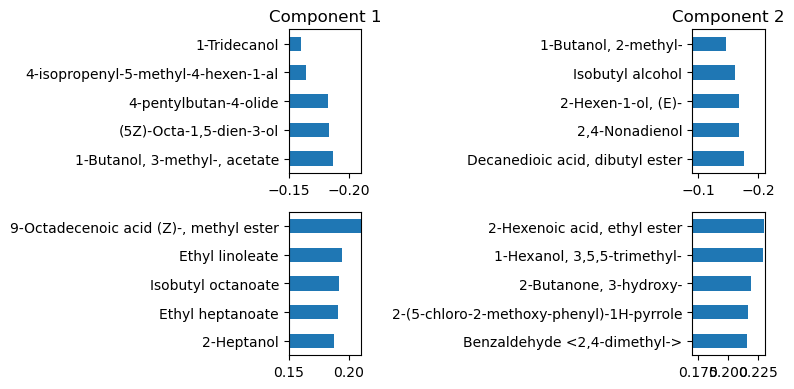

In [132]:
# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(8, 4))

# Plot the first DataFrame
head_L1.plot(kind='barh', ax=axes[0, 0])
axes[0, 0].set_title('Component 1')
axes[0, 0].set_xlim(-0.15, -0.21)  # Set the x-axis limits
axes[0, 0].set_ylabel('')
axes[0, 0].legend('',frameon=False)

# Plot the second DataFrame
head_L2.plot(kind='barh', ax=axes[0, 1])
axes[0, 1].set_title('Component 2')
axes[0, 1].set_xlim(-0.09, -0.21)  # Set the x-axis limits
axes[0, 1].set_ylabel('')
axes[0, 1].legend('',frameon=False)

# Plot the third DataFrame
tail_L1.plot(kind='barh', ax=axes[1, 0])
#axes[1, 0].set_title('Tail 10 - 1')
axes[1, 0].set_xlim(0.15, 0.21)  # Set the x-axis limits
axes[1, 0].set_ylabel('')
axes[1, 0].legend('',frameon=False)

# Plot the fourth DataFrame
tail_L2.plot(kind='barh', ax=axes[1, 1])
#xes[1, 1].set_title('Tail 10 - 2')
axes[1, 1].set_xlim(0.17, 0.23)  # Set the x-axis limits
axes[1, 1].set_ylabel('')
axes[1, 1].legend('',frameon=False)

# Adjust layout
plt.tight_layout()


# Show the plot
plt.show()

In [133]:
# get components names 
Sensory_loadings = Sensory_data.columns.to_list()
# get loadings 
df_Sensory_loadings = pd.DataFrame(Sensory_loadings)
loadings_df = pd.DataFrame(Y_loadings, columns=['L1', 'L2', 'L3'])
# merge them - the order should be the same (yes?)
df_Sensory_loadings_all = df_Sensory_loadings.join(loadings_df)

# top for component 1 
df_Sensory_loadings_all_sorted1 = df_Sensory_loadings_all.sort_values(by=['L1'])
# only get first col and the head and tail 
head_L1 = df_Sensory_loadings_all_sorted1.head(5).iloc[:, 0]
tail_L1 = df_Sensory_loadings_all_sorted1.tail(5).iloc[:, 0]

# top for component 2 
df_Sensory_loadings_all_sorted2 = df_Sensory_loadings_all.sort_values(by=['L2'])
# only get first col and the head and tail 
head_L2 = df_Sensory_loadings_all_sorted2.head(5).iloc[:, 1]
tail_L2 = df_Sensory_loadings_all_sorted2.tail(5).iloc[:, 1]

TypeError: no numeric data to plot

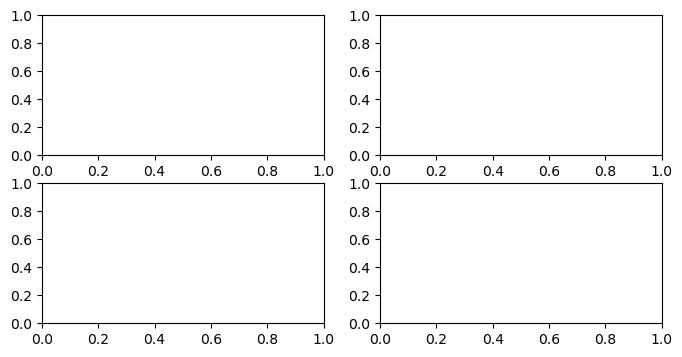

In [134]:
# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(8, 4))

# Plot the first DataFrame
head_L1.plot(kind='barh', ax=axes[0, 0])
axes[0, 0].set_title('Component 1')
axes[0, 0].set_xlim(-0.07, -0.20)  # Set the x-axis limits
axes[0, 0].set_ylabel('')

# Plot the second DataFrame
head_L2.plot(kind='barh', ax=axes[0, 1])
axes[0, 1].set_title('Component 2')
axes[0, 1].set_xlim(-0.03, -0.24)  # Set the x-axis limits
axes[0, 1].set_ylabel('')

# Plot the third DataFrame
tail_L1.plot(kind='barh', ax=axes[1, 0])
#axes[1, 0].set_title('Tail 10 - 1')
axes[1, 0].set_xlim(0, 0.17)  # Set the x-axis limits
axes[1, 0].set_ylabel('')

# Plot the fourth DataFrame
tail_L2.plot(kind='barh', ax=axes[1, 1])
#axes[1, 1].set_title('Tail 10 - 2')
axes[1, 1].set_xlim(0, 0.19)  # Set the x-axis limits
axes[1, 1].set_ylabel('')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Get the scores

In [135]:
GC_index = pd.DataFrame(GC_data_cleaned.index)
X_scores_df = pd.DataFrame(X_scores, columns=['GC_Component_1', 'GC_Component_2', 'GC_Component_3'])
Y_scores_df = pd.DataFrame(Y_scores, columns=['Sensory_Component_1', 'Sensory_Component_2', 'Sensory_Component_3'])
PLSR_scores = GC_index.join(X_scores_df).join(Y_scores_df)
PLSR_scores

,Plot,GC_Component_1,GC_Component_2,GC_Component_3,Sensory_Component_1,Sensory_Component_2,Sensory_Component_3
0,12,3.013559,1.327554,6.897093,2.676036,1.222909,6.671767
1,13,8.661868,-1.274057,0.366990,8.456238,-1.224011,-0.008959
2,14,-4.689517,-1.843378,1.176048,-3.939556,-0.940448,1.412274
3,15,-2.449373,-0.609329,-2.044815,-1.494399,-0.765452,-3.027653
4,17,-1.074215,-5.556009,-0.784075,-0.308306,-6.295912,-0.388295
5,19,0.993424,4.571551,-2.043223,0.916871,4.531047,0.236815
6,20,-1.051672,3.114828,-4.072252,-2.735212,2.819336,-5.304783
7,4,1.617989,0.966025,-1.685828,5.750544,1.293335,-2.973087
8,5,0.678488,-2.488366,-1.777694,-2.992450,-2.102689,-0.464516
9,9,-5.700552,1.791182,3.967756,-6.329764,1.461887,3.846436


### Try Biplot

In [136]:
# get GC components names 
GC_loadings = GC_data_cleaned.columns.to_list()
# get loadings 
df_GC_loadings = pd.DataFrame(GC_loadings, columns=['ID'])
loadings_df = pd.DataFrame(X_loadings, columns=['L1', 'L2', 'L3'])
# merge them - the order should be the same (yes?)
df_GC_loadings_all = df_GC_loadings.join(loadings_df)
df_GC_loadings_all = df_GC_loadings_all.set_index(['ID'])
#df_GC_loadings_all

# Calculate the absolute maximal value for each row
df_GC_loadings_all['max_abs'] = df_GC_loadings_all.abs().max(axis=1)
# Sort the DataFrame by the absolute maximal value
df_GC_loadings_sorted = df_GC_loadings_all.sort_values(by='max_abs', ascending=False)
# Drop the temporary 'max_abs' column if not needed
df_GC_loadings_sorted = df_GC_loadings_sorted.drop(columns='max_abs')


# get GC components names 
Sensory_loadings = Sensory_data.columns.to_list()
# get loadings 
df_Sens_loadings = pd.DataFrame(Sensory_loadings, columns=['ID'])
loadings_df = pd.DataFrame(Y_loadings, columns=['L1', 'L2', 'L3'])
# merge them - the order should be the same (yes?)
df_Sens_loadings_all = df_Sens_loadings.join(loadings_df)
df_Sens_loadings_all = df_Sens_loadings_all.set_index(['ID'])

# Calculate the absolute maximal value for each row
df_Sens_loadings_all['max_abs'] = df_Sens_loadings_all.abs().max(axis=1)
# Sort the DataFrame by the absolute maximal value
df_Sens_loadings_sorted = df_Sens_loadings_all.sort_values(by='max_abs', ascending=False)
# Drop the temporary 'max_abs' column if not needed
df_Sens_loadings_sorted = df_Sens_loadings_sorted.drop(columns='max_abs')

In [137]:
# Get top 5 entries! 
GC_loadings_sorted_Top5 = df_GC_loadings_sorted.head(5)
df_Sens_loadings_sorted_Top5 = df_Sens_loadings_sorted.head(5)

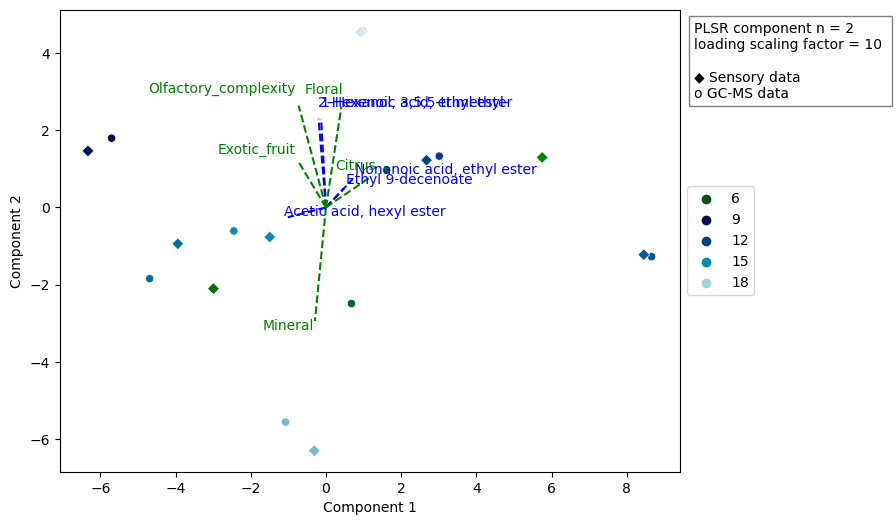

In [138]:
# Create the scatter plot
plt.figure(figsize=(8, 6))

# Your scatterplot
sns.scatterplot(x='GC_Component_1', y='GC_Component_2', data=PLSR_scores, hue='Plot', marker='o', palette='ocean')
sns.scatterplot(x='Sensory_Component_1', y='Sensory_Component_2', data=PLSR_scores, hue='Plot', marker='D',palette='ocean', legend=False)

# Scaling factor for arrow length
scaling_factor = 10  # Adjust this factor to increase or decrease arrow length

# Plot arrows (biplot)
for index, row in GC_loadings_sorted_Top5.iterrows():
    plt.plot([0, row['L1']*scaling_factor], [0, row['L2']*scaling_factor], 'b--')
    # add the text, but I move it even further away 
    plt.text(row['L1']*scaling_factor * 1.1, row['L2']*scaling_factor * 1.1, index, ha='left', va='bottom', color='b')

# Plot arrows (biplot)
for index, row in df_Sens_loadings_sorted_Top5.iterrows():
    plt.plot([0, row['L1']*scaling_factor], [0, row['L2']*scaling_factor], 'g--')
    plt.text(row['L1']*scaling_factor * 1.1, row['L2']*scaling_factor * 1.1, index, ha='right', va='bottom', color='g')

diamond_symbol = '\u25C6'
plt.text(9.8, 4.8, 'PLSR component n = 2 \nloading scaling factor = 10 \n \n\u25C6 Sensory data \no GC-MS data', 
         fontsize=10, ha='left', va='top', 
         bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [151]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

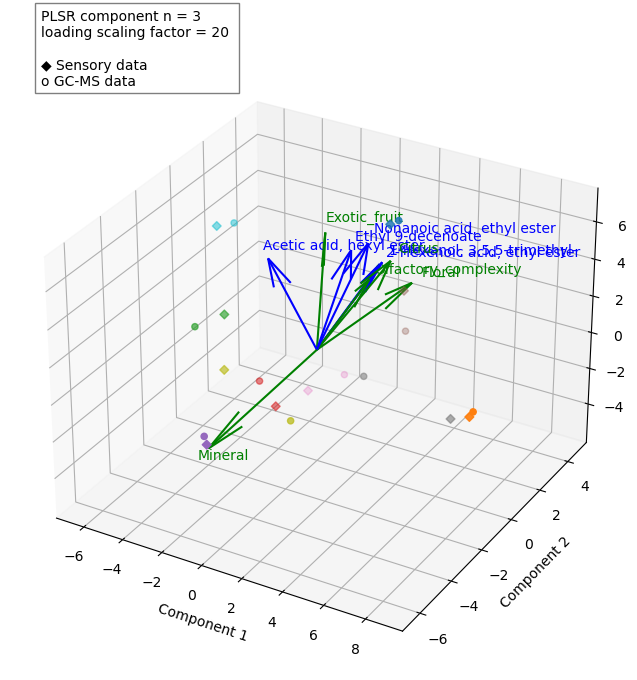

In [153]:

from mpl_toolkits.mplot3d import Axes3D

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Your scatterplot
# Plot GC-MS data
scatter_gc = ax.scatter(PLSR_scores['GC_Component_1'], PLSR_scores['GC_Component_2'], PLSR_scores['GC_Component_3'],
                        c=colors, marker='o', label='GC-MS data', depthshade=True)
# Plot Sensory data
scatter_sensory = ax.scatter(PLSR_scores['Sensory_Component_1'], PLSR_scores['Sensory_Component_2'], PLSR_scores['Sensory_Component_3'],
                             c=colors, marker='D', label='Sensory data', depthshade=True)

# Scaling factor for arrow length
scaling_factor = 20  # Adjust this factor to increase or decrease arrow length

# Plot arrows (biplot) for GC loadings
for index, row in GC_loadings_sorted_Top5.iterrows():
    ax.quiver(0, 0, 0, row['L1']*scaling_factor, row['L2']*scaling_factor, row['L3']*scaling_factor, color='b')
    ax.text(row['L1']*scaling_factor * 1.1, row['L2']*scaling_factor * 1.1, row['L3']*scaling_factor * 1.1, index, color='b')

# Plot arrows (biplot) for Sensory loadings
for index, row in df_Sens_loadings_sorted_Top5.iterrows():
    ax.quiver(0, 0, 0, row['L1']*scaling_factor, row['L2']*scaling_factor, row['L3']*scaling_factor, color='g')
    ax.text(row['L1']*scaling_factor * 1.1, row['L2']*scaling_factor * 1.1, row['L3']*scaling_factor * 1.1, index, color='g')

# Add legend
#ax.legend(loc='upper right')

# Add labels
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

# Add annotation text
diamond_symbol = '\u25C6'
ax.text2D(0.05, 0.95, 'PLSR component n = 3 \nloading scaling factor = 20 \n \n\u25C6 Sensory data \no GC-MS data',
          transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.show()
